# Real-world images

We captured some images of bananas using a Samsumg S21 mobile device to check how the model would perform on real-world.

# Mounting google drive

In order to make it easy to read data from Google Drive, it can be mounted as a "local" unity. This encapsulates the connection to Google API and reduces the amount of coding that would be needed when interacting with Google API

In [1]:
# First check if running on Google Colab
try:
    from google.colab import drive

    # Install required packages
    ! pip install pandarallel
    ! pip install opencv-python

    # Mount Drive
    drive.mount("/content/gdrive", force_remount=True)

    IN_COLAB = True
    file_placement = "/content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data"
except:
    IN_COLAB = False

    # Install required packages
    ! pip install opencv-python

    import os
    file_placement = os.path.join(os.getcwd(), "..", "data")
print("running in colab?", IN_COLAB, "\ndata files:", file_placement)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 1.9 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16672 sha256=6224c64aba120991f667a751f8f941a81b76cb05178c4e5de3c0a1bdbb99db85
  Stored in directory: /root/.cache/pip/wheels/50/4f/1e/34e057bb868842209f1623f195b74fd7eda229308a7352d47f
Successfully built pandarallel
Mounted at /content/gdrive
running in colab? True 
data files: /content/gdrive/MyDrive/08 CS670 Artificial Intelligence/Term Project/data


In [2]:
import torch
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import imageio.v3 as iio
import pathlib

# Reading the new images

We are taking some photos of bananas (and platano) just for fun. Let's load the paths into a DataFrame

In [3]:
if IN_COLAB:
    base_folder = os.path.join(file_placement, "..", "..", "Publishing")
else:
    base_folder = os.path.join(file_placement, "..")
file_placement = os.path.join(base_folder, "photos")
dataset = list(pathlib.Path(file_placement).rglob("*"))
dataset_df = pd.DataFrame(dataset)
dataset_df["path"] = dataset_df[0].astype(str)
dataset_df.head()

,0,path
0,/content/gdrive/MyDrive/08 CS670 Artificial In...,/content/gdrive/MyDrive/08 CS670 Artificial In...
1,/content/gdrive/MyDrive/08 CS670 Artificial In...,/content/gdrive/MyDrive/08 CS670 Artificial In...
2,/content/gdrive/MyDrive/08 CS670 Artificial In...,/content/gdrive/MyDrive/08 CS670 Artificial In...
3,/content/gdrive/MyDrive/08 CS670 Artificial In...,/content/gdrive/MyDrive/08 CS670 Artificial In...
4,/content/gdrive/MyDrive/08 CS670 Artificial In...,/content/gdrive/MyDrive/08 CS670 Artificial In...


# Pre-processing

We need to apply the same standardization to validation set that we have applied to Train and Test set. For the pre-processing, we define again the same function used before

In [4]:
import cv2
def resize_and_pad(image, height = 512, width = 512, padColor = 0):
  h, w, c = image.shape
  size = (height, width)
  sh, sw = size

  # Remove alpha channel if the image has 4 channels
  if c > 3:
    image = image[:,:,:3]

  # interpolation method
  if h > sh or w > sw: # shrinking image
    interp = cv2.INTER_AREA
  else: # stretching image
    interp = cv2.INTER_CUBIC

  # aspect ratio of image
  aspect = w/h

  # compute scaling and pad sizing
  if aspect > 1: # horizontal image
    new_w = sw
    new_h = np.round(new_w/aspect).astype(int)
    pad_vert = (sh-new_h)/2
    pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
    pad_left, pad_right = 0, 0
  elif aspect < 1: # vertical image
    new_h = sh
    new_w = np.round(new_h*aspect).astype(int)
    pad_horz = (sw-new_w)/2
    pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
    pad_top, pad_bot = 0, 0
  else: # square image
    new_h, new_w = sh, sw
    pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

  # set pad color
  if len(image.shape) == 3 and not isinstance(padColor, (list, tuple,
      np.ndarray)): # color image but only one color provided
    padColor = [padColor]*3

  # Recalc the aspect ratio
  aspect = w/h
  scaled_img = cv2.resize(image, (new_w, new_h), interpolation=interp)
  scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=0)

  return scaled_img

# Loading saved model

We are going to load the model we have saved in the previous step/notebook in order to use it to predict the "new cases" (images from our validation set)

In [5]:
model_folder = os.path.join(base_folder, "saved_model")
model = torch.load(os.path.join(model_folder, "fresh_banana_classification.pth"), map_location=torch.device('cpu'))

# Prediction function

Now we create a function that will receive the model and the image. It applies the pre-processing transformation and then loads the image on a tensor, applying the transformations we have applied when loading the train and test dataset.

It also adjusts the dimensions to match of what we have used to train and test (array of 3D images - therefore 4 dimensions).

After the transformations, it used the saved model to predict the image and outputs True if the prediction is for a fresh banana or False otherwise.

In [6]:
def is_fresh(model, image):
    from PIL import Image
    image = resize_and_pad(image)
    image = Image.fromarray(image)
    trans = transforms.Compose([
        transforms.Resize(255),
        transforms.ToTensor()
        ])
    input = trans(image)
    input = input.view(1, 3, 255, 255)
    output = model(input).argmax(axis=1)

    fresh = False
    if output[0].numpy() == 0:
        fresh = True

    return image, fresh

In [7]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)

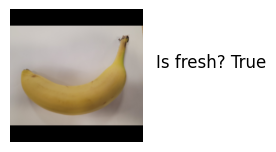

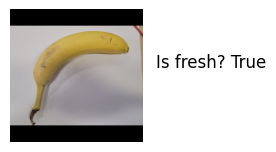

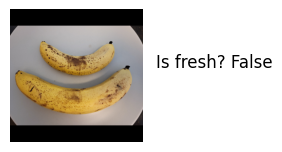

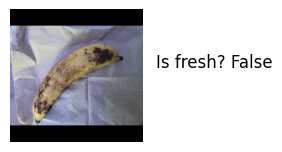

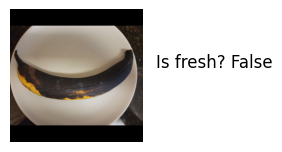

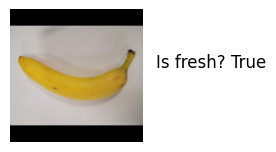

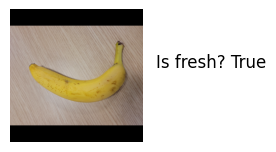

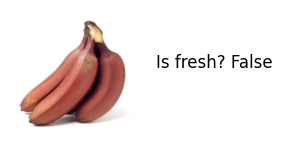

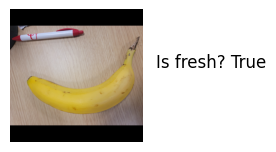

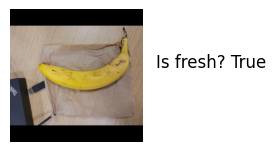

In [9]:
images_so_far = 0
num_images = len(dataset_df.index) + 1
for index, each_photo in dataset_df.iterrows():
    fig = plt.figure(figsize=(10, 10))
    image = iio.imread(each_photo["path"])
    # plt.imshow(image)
    # plt.show()
    image, predicted_freshness = is_fresh(model, image)
    images_so_far += 1
    ax = plt.subplot(num_images//2, 2, images_so_far)
    ax.axis('off')
    ax.set_title(f"Is fresh? {predicted_freshness}", x=1.1, y=.5, loc="left")
    # imshow(image)

    # print("Is fresh?", predicted_freshness)
    plt.imshow(image)
    plt.show()